# Marginalizing over the DM variation hyperparameters: PCA approach

This notebook presents code used to carry out the analysis described in Appendix B of *add link*. In particular, we take the example of the EPTA pulsar J1909-3744 and carry out inference on the red noise hyperparameters marginalizing over white noise and DM variations. The covariance between the RN and DM hyperparameters is modeled through a principal component analysis (PCA) approach.

The noise model for pulsar J1909-3744 includes: white noise (efac and equad specific for each observing backend), red noise and DM variations.

In [14]:
import numpy as np
import os, sys, json
import dill as pickle
import scipy.linalg as sl
from numpy import linalg as LA

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from enterprise.pulsar import Pulsar
from enterprise.signals import selections
from enterprise.signals.selections import no_selection, Selection
from enterprise.signals import parameter, white_signals, utils, gp_signals, signal_base
from enterprise.signals.parameter import function
import enterprise.constants as const
from tqdm import tqdm

import la_forge.gp as lfgp
import corner

import sere_enterprise as sere

In [31]:
####################################   FUNCTIONS    #################################### 

# build PTA object
#--------------------------------------------------------------------------------

def pulsar_model(psr, model_base, inc_chrom=True, inc_dmdip=True, fix_dip=True, fix_chrom=True):

    # chromatic noise
    if psr.name == 'J1600-3053' and inc_chrom == True:
        
        if fix_chrom == True:
            chrom = sere.chromatic_noise_block(components=93,gp_kernel='diag', psd='flat_powerlaw',gamma_val=5, logA_val=-12,logk_val=-5)
        else:
            chrom = sere.chromatic_noise_block(components=93,gp_kernel='diag', psd='flat_powerlaw')  
        model = model_base + chrom

    # DM dip
    elif psr.name == 'J1713+0747' and inc_dmdip == True:
        
        dm_expdip_tmin=[54650, 57490]
        dm_expdip_tmax=[54850, 57530]
        tmin = (dm_expdip_tmin if isinstance(dm_expdip_tmin, list)
                else [dm_expdip_tmin])
        tmax = (dm_expdip_tmax if isinstance(dm_expdip_tmax, list)
                else [dm_expdip_tmax])
        num_dmdips = 2
        dm_expdip_idx=[4,1]
        dm_expdip_idx = (dm_expdip_idx if isinstance(dm_expdip_idx,list)
                                        else [dm_expdip_idx]*int(num_dmdips))
        dm_expdip_sign='negative'
        dm_expdip_sign = (dm_expdip_sign if isinstance(dm_expdip_sign,list)
                                            else [dm_expdip_sign]*int(num_dmdips))

        if fix_dip == True:
            for dd in range(num_dmdips):
                dmdip = sere.dm_exponential_dip(tmin=tmin[dd], tmax=tmax[dd],
                                                        idx=dm_expdip_idx[dd],
                                                        sign=dm_expdip_sign[dd],
                                                        name='dmexp_{0}'.format(dd+1),
                                                        t0_dmexp_val=57510, log10_Amp_dmexp_val=-6, log10_tau_dmexp_val=1.5)
        else:
            for dd in range(num_dmdips):
                dmdip = sere.dm_exponential_dip(tmin=tmin[dd], tmax=tmax[dd],
                                                        idx=dm_expdip_idx[dd],
                                                        sign=dm_expdip_sign[dd],
                                                        name='dmexp_{0}'.format(dd+1))
        model = model_base + dmdip

    else:
        model = model_base

    return model(psr)


def build_pta (psrs, fix_rn=True, fix_dm=True, fix_wn=True, logA_red=-15, gamma_red=4, logA_dm=-16, gamma_dm=3, log_kappa=-6, inc_chrom=True, inc_dmdip=True, fix_dip=True, fix_chrom=True, inc_crn=True, hd=True, inc_dm=False):

    # find the maximum time span to set GW frequency sampling
    tmin = [p.toas.min() for p in psrs]
    tmax = [p.toas.max() for p in psrs]
    Tspan = np.max(tmax) - np.min(tmin)

    # timing model
    tm = gp_signals.MarginalizingTimingModel(use_svd=True)

    # white noise
    if fix_wn == True:
        efac = parameter.Constant(1.0)
        equad = parameter.Constant(-6)
    else:
        efac = parameter.Uniform(0.1,5)
        equad = parameter.Uniform(-10,-5)
    ef = white_signals.MeasurementNoise(efac=efac, selection=Selection(selections.by_backend))
    eq = white_signals.TNEquadNoise(log10_tnequad=equad, selection=Selection(selections.by_backend))

    # red noise
    if fix_rn == True:
        rn_log10_A = parameter.Constant(logA_red)
        rn_gamma = parameter.Constant(gamma_red)
        rn_log10_kappa = parameter.Constant(log_kappa)
    else:
        rn_log10_A = parameter.Uniform(-18, -12)
        rn_log10_kappa = parameter.Uniform(-9,-4)
        rn_gamma = parameter.Uniform(0,7)
    rn_pl = sere.powerlaw_flat_tail(log10_A=rn_log10_A, gamma=rn_gamma, log10_kappa=rn_log10_kappa)
    rn = gp_signals.FourierBasisGP(spectrum=rn_pl, components=30, Tspan=Tspan)

    # DM variations
    if fix_dm == True:
        dm_log10_A = parameter.Constant(logA_dm)
        dm_gamma = parameter.Constant(gamma_dm) 
        dm_log10_kappa = parameter.Constant(log_kappa)
    else:
        dm_log10_A = parameter.Uniform(-18, -12)
        dm_gamma = parameter.Uniform(0,7)
        dm_log10_kappa = parameter.Uniform(-9,-4)
    pl_dm = sere.powerlaw_flat_tail(log10_A=dm_log10_A, gamma=dm_gamma, log10_kappa=dm_log10_kappa)
    dm_basis = utils.createfourierdesignmatrix_dm(nmodes=100)
    dm = gp_signals.BasisGP(priorFunction=pl_dm, basisFunction=dm_basis, name='dm')

    if hd == True:
        # HD correlated background
        crn = sere.common_red_noise_block(psd='powerlaw', prior='log-uniform', Tspan=Tspan, components=9,  logmin=-15.5, logmax=-13.5, gamma_val=None, name='gw',orf='hd')
    else:
        # common red noise signal (uncorrelated)
        crn = sere.common_red_noise_block(psd='powerlaw', prior='log-uniform', Tspan=Tspan, components=9,  logmin=-15.5, logmax=-13.5, gamma_val=None, name='crn')

    # base model
    model_base = tm + ef + eq + rn 
    
    if inc_dm == True:
        model_base += dm

    if inc_crn == True:
        model_base += crn

    return signal_base.PTA([pulsar_model(psr,model_base,inc_chrom=inc_chrom, inc_dmdip=inc_dmdip, fix_dip=fix_dip, fix_chrom=fix_chrom) for psr in psrs])



In [29]:
# FOURIER LIKELIHOOD FUNCTION

def log_likelihood_Fourier(xs):

    '''
        New Fourier likelihood for PTA analysis
        (simplified version for SPNA with RN and DM var only)
        it contains modifications to make it compatible with PCA results
    '''
    params = xs if isinstance(xs, dict) else pta_fl.map_params(xs)
    loglike = 0

    temp = pta_fl.get_phiinv(params, logdet=True)
    phiinv = np.diag(temp[0][0])
    nf = int(len(temp[0][0]))
    logdet_phi = temp[0][1]
    phiinv_prime = np.zeros((nf+n_t_prime,nf+n_t_prime))
    phiinv_prime[:nf,:nf] = phiinv - np.diag(phiinv_0[:nf])
    Sigma_inv = Sigma_0_inv + phiinv_prime
    
    Li, lower = sl.cho_factor(Sigma_inv, lower=True)
    Sigma = sl.cho_solve((Li,True), np.identity(len(Li)))
    expval = sl.cho_solve((Li,True), Si0_a_hat)

    loglike += -0.5 * np.sum(pta_fl.get_rNr_logdet(params))   
    loglike += sum(pta_fl.get_logsignalprior(params))
    logdet_sigma = np.sum(2 * np.log(np.diag(Li)))
    loglike += 0.5 * (np.dot(Si0_a_hat, expval) - logdet_sigma - logdet_phi)
    
    return loglike

In [ ]:
##########################  MAIN CODE ###########################################

In [ ]:
# pulsar name
name = 'J1909-3744'

# directories
home_dir = '...'
data_dir = home_dir + '...'

# pulsar object
psr = Pulsar(data_dir+name+'.par',data_dir+name+'_all.tim')

In [5]:
# building a pta object where the parameters for white noise and DM variations are free parameters
pta_0 = build_pta([psr], fix_wn=False, fix_dm=False, inc_crn=False, logA_red=-12, gamma_red=5, log_kappa=-5)
pta_0.param_names

['J1909-3744_NRT.NUPPI.1484_efac',
 'J1909-3744_NRT.NUPPI.1484_log10_tnequad',
 'J1909-3744_NRT.NUPPI.1854_efac',
 'J1909-3744_NRT.NUPPI.1854_log10_tnequad',
 'J1909-3744_NRT.NUPPI.2154_efac',
 'J1909-3744_NRT.NUPPI.2154_log10_tnequad',
 'J1909-3744_NRT.NUPPI.2539_efac',
 'J1909-3744_NRT.NUPPI.2539_log10_tnequad',
 'J1909-3744_dm_gamma',
 'J1909-3744_dm_log10_A',
 'J1909-3744_dm_log10_kappa']

### Obtaining the Fourier coefficients samples from a chain of WN+DM parameter samples

In [6]:
# reading the chain (previously obtained) of WN and DM parameter samples
chain_dir = data_dir + 'rn_fixed/chain_1.txt'
rnfixed_chain = np.loadtxt(chain_dir)

In [10]:
lfrec = lfgp.Signal_Reconstruction([psr], pta_0, rnfixed_chain, burn=0)
lfrec.reconstruct_coeffs = sere.reconstruct_coeffs

# how many samples from the rnfixed_chain to read
n_samples = int(1e4)

# now I define the idx of the random chain samples (after removing the burn part)
burn = int(0.25 * rnfixed_chain.shape[0]) 
chain_no_burn = rnfixed_chain[burn:,:]
idx = []
for _ in range(n_samples):
    i = int(np.random.randint(len(chain_no_burn)))
    idx.append(i)
idx = np.array(idx)

# taking the samples
a_samples = np.vstack([lfrec.reconstruct_coeffs(lfrec, mlv=False, idx=i)[0] for i in idx])

# Mean and Sigma:
mu_a = np.mean(a_samples, axis=0)
print(mu_a.shape)  # In this case I should have 30*2 RN components and 100*2 DM components = 260
Sigma_a = np.cov(a_samples.T)
print(Sigma_a.shape)

(260,)
(260, 260)


# PCA approach

(From now on, I will discard all the samples obtained for the DM Fourier coefficients and consider the RN Fourier coefficients only).

The PCA approach allows to reduce the dimensionality of a problem, minimizing the information loss (see Appendix B of our paper for more details).

In [11]:
# selecting the RN Fourier coefficients
a_samples_rn = a_samples[:,:60]

# I need to do a new matrix of the noise hyperparams samples to agree
# dimensionally with the a_samples one: from each noise hyperparm sample I 
# got 100 a_ samples => I need to duplicate each row of chain_no_burn 100 times
chain_x100 = np.vstack([np.tile(chain_no_burn[id,:], (100, 1)) for id in idx])
chain_x100.shape

# buildi the x = [a, theta] array with the RN fourier coeff and the noise parameters (10)
x = np.hstack([a_samples_rn, chain_x100[:,:-4]])
Sigma_x = np.cov(x.T)
print(x.shape, Sigma_x.shape) #(n_a_samples, 60+10) and (60+10, 60+10)

(1000000, 70) (70, 70)


In [12]:
# matrix to which I want to apply PCA
C = Sigma_x[:60,60:] # matrix that describes the covariance between the Fourier coeff. and the noise params theta
CTC = np.dot(C.T,C)
print(C.shape, CTC.shape) # (60, 10)  (10, 10)

(60, 10) (10, 10)


In [15]:
# eigenvalues decomposition
eigenvalues, eigenvectors = LA.eig(CTC) 
index_sorted = np.argsort(eigenvalues)[::-1] # sorted from higher to lower values
eigenvalues = eigenvalues[index_sorted] 
eigenvectors = eigenvectors[:,index_sorted] # each column is an eigenvector
print(eigenvalues.shape, eigenvectors.shape) # (10,) (10, 10)

(10,) (10, 10)


In [17]:
# how many components should I keep for the PCA? 
g = []
for i in range(len(eigenvalues)):
    g.append(float(np.sum(eigenvalues[:(i+1)])))
g = np.array(g)
g_perc = g/g[-1]*100
print(g_perc)
n_t_prime = np.where(g_perc > 99.8)[0][0]+1   # (in this case: n_t_prime = 4 or 3)
w = eigenvectors[:,:n_t_prime]
w.shape

[ 95.60840709  99.58319043  99.95403726  99.97904281  99.99953954
  99.99996411  99.99999055  99.99999557  99.99999962 100.        ]


(10, 3)

In [18]:
# transformation matrix
T = np.zeros((60+n_t_prime,60+10))
T[:60,:60] = np.identity(60)
T[60:,60:] = w.T

# new covariance matrix
Sigma_xp = np.dot(T,np.dot(Sigma_x,T.T))
Sigma_xp.shape # (60 + n_t_prime, 60 + n_t_prime)

(63, 63)

# RN inference with the Fourier likelihood

In [20]:
# Sigma_0_inv
Sigma_0_inv = sl.inv(Sigma_xp) 
Li = sl.cholesky(Sigma_0_inv, lower=True)
Sigma_0_logdet = -2 * np.sum(np.log(np.diag(Li)))

# phiinv_0
phiinv_0 = np.zeros((60+n_t_prime))
phiinv_0[:60] = pta_0.get_phiinv([])[0][:60]
phiinv_logdet_0 = np.sum(np.log(phiinv_0))

# a_hat
theta_prime = np.mean(np.dot(w.T,x[:,60:].T), axis=1)
a_hat = np.concatenate((mu_a[:60], theta_prime))

# Sigma_0 * a_hat
Si0_a_hat = np.dot(Sigma_0_inv, a_hat)

/local/user/serena.valtolina/ipykernel_2865829/63405495.py:9: RuntimeWarning: divide by zero encountered in log
  phiinv_logdet_0 = np.sum(np.log(phiinv_0))


In [32]:
# PTA object with only red noise parameters free
pta_fl = build_pta([psr], fix_rn=False, inc_crn=False)
pta_fl.param_names

['J1909-3744_red_noise_gamma',
 'J1909-3744_red_noise_log10_A',
 'J1909-3744_red_noise_log10_kappa']

In [33]:
# test
x0 = np.hstack([p.sample() for p in pta_fl.params])
print('ln_likelihood check : ',log_likelihood_Fourier(x0),'\n')

ln_likelihood check :  29126.993976909627 



In [ ]:
# sampling
x0 = np.hstack([p.sample() for p in pta_fl.params])
ndim = len(x0)
cov = np.diag(np.ones(ndim) * 0.01**2)

groups = None
Num = 1e6
outdir = data_dir + '...' 
sampler = ptmcmc(ndim, log_likelihood_Fourier, pta_fl.get_lnprior, cov, groups=groups, outDir=outdir, resume=False)

In [ ]:
# sampling!
sampler.sample(x0, Num, burn=10000)

In [34]:
# RESULTS:

# RN hyperparameters chain (obtained with the Fourier likelihood)
outdir = data_dir + '...'
chain = np.loadtxt(outdir+'/chain_1.txt')
burn = int(0.25 * chain.shape[0])

# full spna chain (for comparison, obtained with the time-domain likelihood)
spna_chain_dir = data_dir + 'full_spna/chain_1.txt'
spna_chain = np.loadtxt(spna_chain_dir)
burn_spna = int(0.25 * spna_chain.shape[0]) 

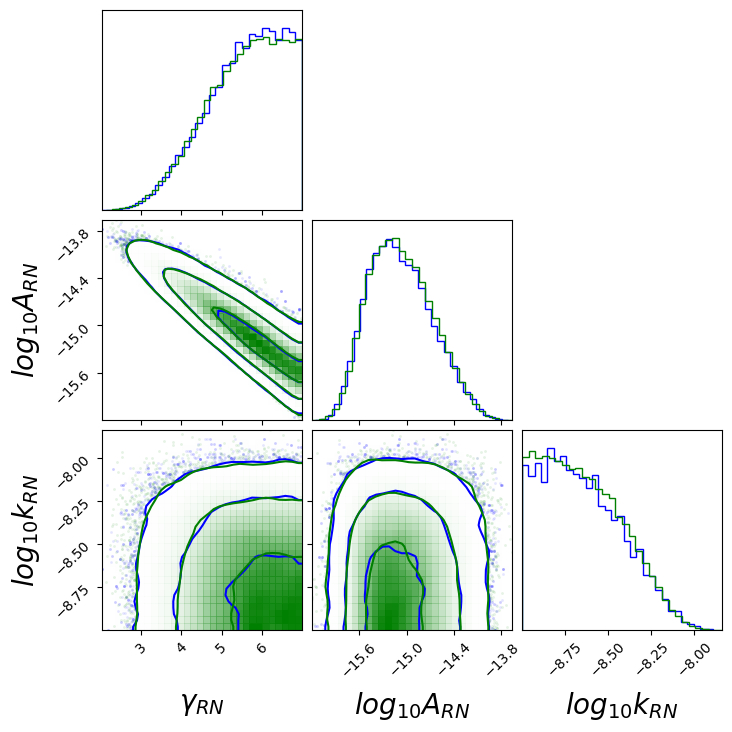

In [36]:
exp_lev = np.array([1, 2, 3])
mp_array = 1 - np.exp(-0.5*exp_lev**2)

wo = np.ones(len(spna_chain[burn_spna:,0]))/len(spna_chain[burn_spna:,0])
w = np.ones(len(chain[burn:,0]))/len(chain[burn:,0])

pars = ['$\gamma_{RN}$', '$log_{10}A_{RN}$', '$log_{10}k_{RN}$' ]
title_font_size = 20

fig = corner.corner(spna_chain[burn_spna:,-7:-4], 30, weights=wo,levels=mp_array, color='blue', smooth=True, labels=pars, label_kwargs={"fontsize": title_font_size});
fig1 = corner.corner(chain[burn:,:-4], 30, weights=w, levels=mp_array, color='green', smooth=True, fig=fig);
